/Users/mitsuki/Desktop/Robotics/Roboenv/lib/python3.9/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


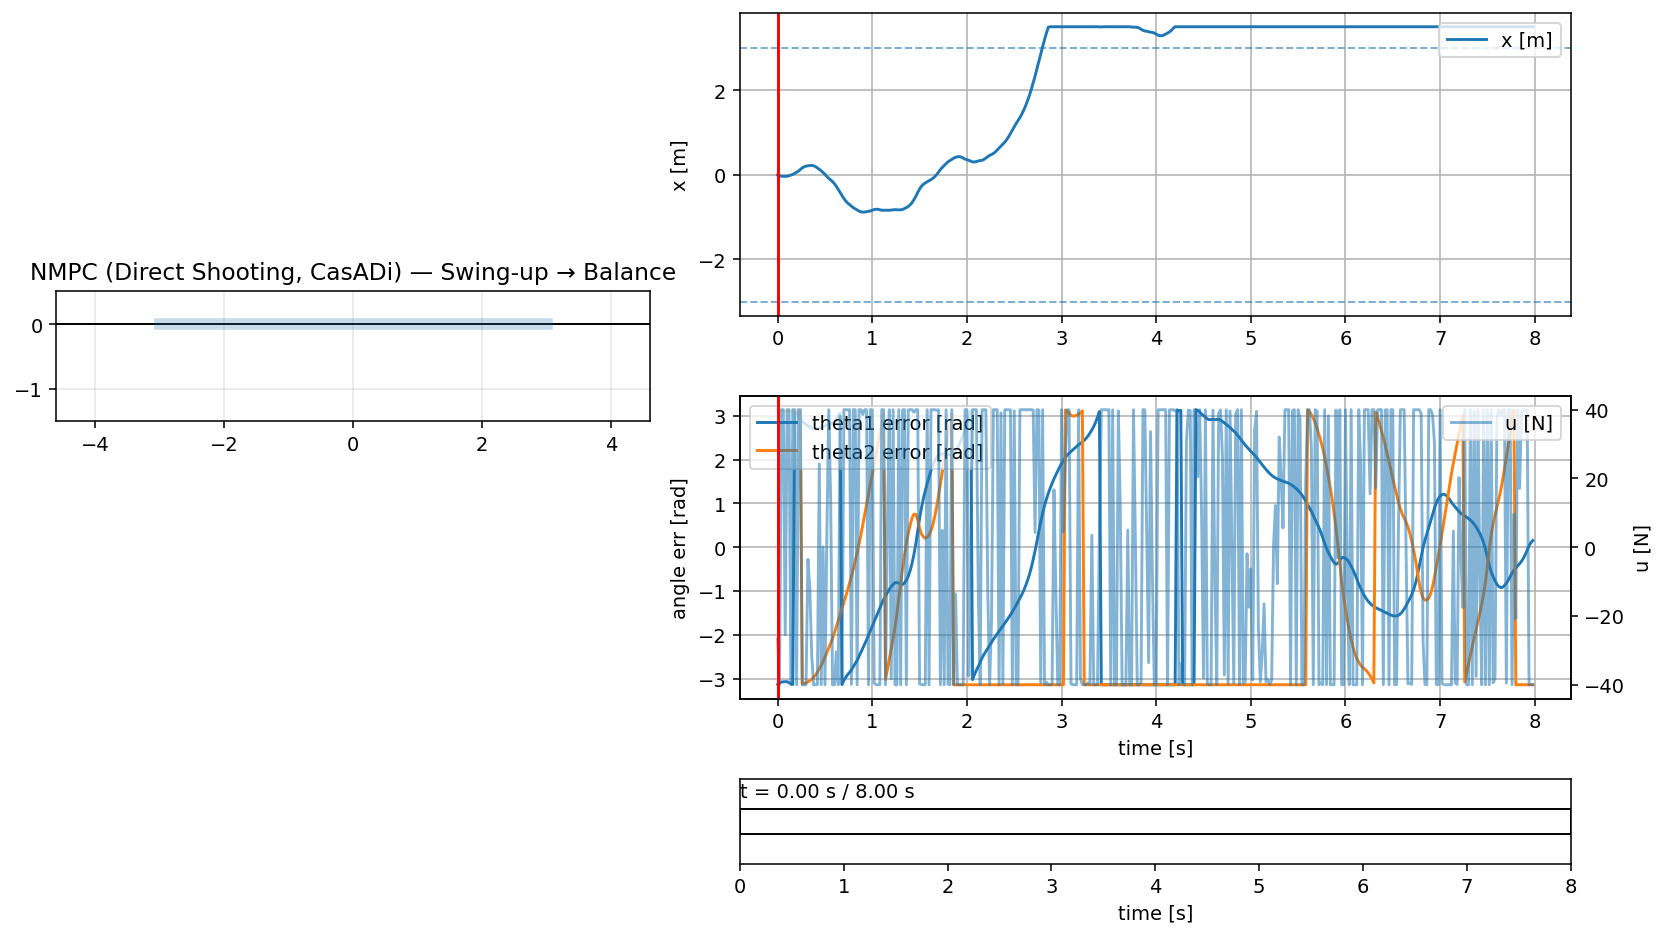

In [47]:
# nmpc_cart_double_pendulum_full.py
# Nonlinear MPC (direct multiple shooting) for Cart + Double Inverted Pendulum
# - Lagrangian model (M,C,g,viscous)
# - CasADi + IPOPT
# - RK4 discretization
# - Soft rail penalty, input smoothing, early x-nudge
# - Receding horizon + warm start
# - Robustness: M regularization, integration clamp, solver fallback
# - Plots + Animation with synced red time cursor and progress bar
# ---------------------------------------------------------------

import numpy as np
import casadi as ca
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle

# ============== Parameters ==============
M, m1, m2 = 1.2, 0.35, 0.25
l1, l2    = 0.70, 0.60
I1        = (1/12)*m1*l1**2
I2        = (1/12)*m2*l2**2
c_cart, c1, c2 = 0.15, 0.02, 0.02
g = 9.81

# NMPC settings
DT    = 0.02          # [s]
H     = 60            # horizon steps (≈1.2 s)
SIM_T = 8.0           # total sim [s]
Umax  = 40.0          # input saturation [N]

# Cost weights
Qx      = 0.4         # cart position
Qtheta  = 60.0        # (1+cos(th)) shaping
Qv      = 1.0         # velocities
Ru      = 1e-3        # control effort
Rdu     = 1e-2        # control rate

# Terminal weights
QxN     = 4.0
QthetaN = 200.0
QvN     = 3.0

# Rail soft bound
X_LIM      = 3.0
SOFT_BND_W = 300.0

# Early "right nudge" for swing-up (reference on x along horizon)
NUDGE_AMP  = 0.18      # [m]
NUDGE_TAU  = 0.5       # [s], x_ref[k] = NUDGE_AMP * exp(-t/NUDGE_TAU)

# Integration clamp (simulation only; tiny guardrail)
Q_HARD, DQ_HARD, TH_HARD, W_HARD = 3.5, 20.0, 4*np.pi, 40.0

# IPOPT options
IPOPT_OPTS = {
    'ipopt.max_iter': 200,
    'ipopt.tol': 1e-4,
    'ipopt.constr_viol_tol': 1e-6,
    'ipopt.print_level': 0,
    'print_time': 0,
}

# ============== Helpers ==============
def wrap_pi(a):  # (-π,π]
    return (a + np.pi)%(2*np.pi) - np.pi

def clamp_state_np(x):
    x = x.copy()
    x[0] = np.clip(x[0], -Q_HARD,  Q_HARD)
    x[3] = np.clip(x[3], -DQ_HARD, DQ_HARD)
    x[1] = np.clip(x[1], -TH_HARD, TH_HARD)
    x[2] = np.clip(x[2], -TH_HARD, TH_HARD)
    x[4] = np.clip(x[4], -W_HARD,  W_HARD)
    x[5] = np.clip(x[5], -W_HARD,  W_HARD)
    return x

# ============== Symbolic dynamics from Lagrangian ==============
X = ca.SX.sym('X', 6)   # [x, th1, th2, xd, th1d, th2d]
u = ca.SX.sym('u')

x, th1, th2, xd, th1d, th2d = X[0], X[1], X[2], X[3], X[4], X[5]

x1 = x + (l1/2)*ca.sin(th1);       y1 = -(l1/2)*ca.cos(th1)
x2 = x + l1*ca.sin(th1) + (l2/2)*ca.sin(th2)
y2 = -l1*ca.cos(th1) - (l2/2)*ca.cos(th2)

qd = ca.vertcat(xd, th1d, th2d)
J1 = ca.jacobian(ca.vertcat(x1,y1), ca.vertcat(x,th1,th2))
J2 = ca.jacobian(ca.vertcat(x2,y2), ca.vertcat(x,th1,th2))
V1 = J1 @ qd
V2 = J2 @ qd

T  = 0.5*M*xd**2 + 0.5*m1*ca.dot(V1,V1) + 0.5*I1*th1d**2 + 0.5*m2*ca.dot(V2,V2) + 0.5*I2*th2d**2
Vg = m1*g*(-y1) + m2*g*(-y2)
L  = T - Vg

D = 0.5*c_cart*xd**2 + 0.5*c1*th1d**2 + 0.5*c2*th2d**2

q   = ca.vertcat(x, th1, th2)
dqv = ca.vertcat(xd, th1d, th2d)

dLdqd = ca.vertcat(*[ca.gradient(L, v)  for v  in [xd, th1d, th2d]])
dLdq  = ca.vertcat(*[ca.gradient(L, qi) for qi in [x, th1, th2]])

Mmat = ca.SX.zeros(3,3)
for i in range(3):
    for j in range(3):
        Mmat[i,j] = ca.jacobian(dLdqd[i], dqv[j])

Cvec = ca.SX.zeros(3,1)
for i in range(3):
    tmp = 0
    for k in range(3):
        tmp += ca.jacobian(dLdqd[i], q[k]) * dqv[k]
    Cvec[i] = tmp - dLdq[i]

dD = ca.vertcat(ca.gradient(D, xd), ca.gradient(D, th1d), ca.gradient(D, th2d))
Qgen = ca.vertcat(u, 0, 0) - dD

# small regularization on M for robustness
qdd = ca.solve(Mmat + 1e-9*ca.SX.eye(3), Qgen - Cvec)

Xdot = ca.vertcat(xd, th1d, th2d, qdd[0], qdd[1], qdd[2])
f    = ca.Function('f', [X,u], [Xdot])

def rk4_step_ca(Xk, Uk, dt):
    k1 = f(Xk, Uk)
    k2 = f(Xk + 0.5*dt*k1, Uk)
    k3 = f(Xk + 0.5*dt*k2, Uk)
    k4 = f(Xk +     dt*k3, Uk)
    return Xk + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_step_np(xk: np.ndarray, uk: float, dt: float):
    k1 = np.array(f(xk, uk)).squeeze()
    k2 = np.array(f(xk + 0.5*dt*k1, uk)).squeeze()
    k3 = np.array(f(xk + 0.5*dt*k2, uk)).squeeze()
    k4 = np.array(f(xk +     dt*k3, uk)).squeeze()
    xn = xk + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return clamp_state_np(xn)

# ============== Build NMPC (direct multiple shooting) ==============
nx = 6
Xsym = ca.SX.sym('Xsym', nx, H+1)
Usym = ca.SX.sym('Usym', H)
X0par = ca.SX.sym('X0', nx)       # initial state parameter
u_prev0 = ca.SX.sym('u_prev0')    # for du penalty at k=0

J = 0
G_list = []
for k in range(H):
    xk = Xsym[:,k]
    uk = Usym[k]
    x_next = rk4_step_ca(xk, uk, DT)
    G_list.append(Xsym[:,k+1] - x_next)

    # early nudge reference on x
    t_k = k*DT
    xref = NUDGE_AMP * ca.exp(-t_k/NUDGE_TAU)

    # stage cost
    J += Qx*(xk[0]-xref)**2 \
       + Qtheta*(1 + ca.cos(xk[1])) \
       + Qtheta*(1 + ca.cos(xk[2])) \
       + Qv*(xk[3]**2 + xk[4]**2 + xk[5]**2) \
       + Ru*(uk**2)

    # input slew (k>0)
    if k==0:
        J += Rdu*((uk - u_prev0)**2)
    else:
        J += Rdu*((Usym[k] - Usym[k-1])**2)

    # rail soft bound
    if X_LIM is not None:
        J += SOFT_BND_W * (ca.fmax(0, ca.fabs(xk[0]) - X_LIM))**2

# terminal cost
xN = Xsym[:, H]
J += QxN*(xN[0]**2) \
   + QthetaN*(1 + ca.cos(xN[1])) + QthetaN*(1 + ca.cos(xN[2])) \
   + QvN*(xN[3]**2 + xN[4]**2 + xN[5]**2)

# constraints: initial state + shooting defects
G = ca.vertcat(Xsym[:,0] - X0par, *G_list)

# decision vector
w   = ca.vertcat(ca.reshape(Xsym, -1, 1), Usym)
n_w = int(w.shape[0])

# bounds (states unbounded: we used soft bounds; inputs hard-saturated)
lbw = -ca.inf*ca.DM.ones(n_w)
ubw =  ca.inf*ca.DM.ones(n_w)

# set input bounds
for k in range(H):
    idx_u = (H+1)*nx + k
    lbw[idx_u] = -Umax
    ubw[idx_u] =  Umax

# constraints equality g=0
lbg = ca.DM.zeros(G.shape[0])
ubg = ca.DM.zeros(G.shape[0])

nlp = {'x': w, 'f': J, 'g': G, 'p': ca.vertcat(X0par, u_prev0)}
solver = ca.nlpsol('solver', 'ipopt', nlp, IPOPT_OPTS)

def pack_vars(Xguess, Uguess):
    return np.concatenate([Xguess.reshape(-1), Uguess.reshape(-1)])
def unpack_vars(wvec):
    Xopt = np.array(wvec[:(H+1)*nx]).reshape(nx, H+1)
    Uopt = np.array(wvec[(H+1)*nx:])
    return Xopt, Uopt

# ============== Closed-loop simulation (receding horizon) ==============
steps = int(SIM_T/DT)
xk = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])     # downward-downward
u_prev = 0.0

# warm start
X_guess = np.tile(xk.reshape(-1,1), (1, H+1))
U_guess = np.zeros(H)

# logs
t_log  = []
X_log  = []
U_log  = []

lam_g = None
for i in range(steps):
    pvec = np.concatenate([xk, np.array([u_prev])])
    w0   = pack_vars(X_guess, U_guess)

    try:
        sol = solver(x0=w0, p=pvec, lbg=lbg, ubg=ubg, lbx=lbw, ubx=ubw)
        w_opt = np.array(sol['x']).squeeze()
        Xopt, Uopt = unpack_vars(w_opt)
    except Exception as e:
        # fallback: keep previous guess (robustness)
        Xopt, Uopt = X_guess.copy(), U_guess.copy()

    u_apply = float(np.clip(Uopt[0], -Umax, Umax))

    # simulate one step numerically
    xk = rk4_step_np(xk, u_apply, DT)
    u_prev = u_apply

    # warm-start shift
    X_guess = np.hstack([Xopt[:,1:], Xopt[:,-1:]])
    U_guess = np.hstack([Uopt[1:], Uopt[-1]])

    # logs
    t_log.append(i*DT); X_log.append(xk.copy()); U_log.append(u_apply)

t_log = np.array(t_log)
X_log = np.array(X_log)
U_log = np.array(U_log)

# ============== Plots ==============
wrap = lambda a: (a + np.pi)%(2*np.pi) - np.pi

x_tr  = X_log[:,0]
th1_e = np.array([wrap(a - np.pi) for a in X_log[:,1]])
th2_e = np.array([wrap(a - np.pi) for a in X_log[:,2]])
xd_tr  = X_log[:,3]
th1d_tr= X_log[:,4]
th2d_tr= X_log[:,5]

Tsim = steps*DT
t_plot = np.arange(steps+1)*DT

fig = plt.figure(figsize=(12,6.8))
gs  = fig.add_gridspec(3, 2, width_ratios=[1.0, 1.4], height_ratios=[1.0, 1.0, 0.28])
ax_anim = fig.add_subplot(gs[0:2, 0])
ax_x    = fig.add_subplot(gs[0, 1])
ax_th   = fig.add_subplot(gs[1, 1])
ax_bar  = fig.add_subplot(gs[2, 1])
ax_blank= fig.add_subplot(gs[2, 0]); ax_blank.axis('off')

# --- animation panel ---
def links_xy(Xsnap):
    x, th1, th2 = Xsnap[0], Xsnap[1], Xsnap[2]
    O  = np.array([x, 0.0])
    P1 = np.array([x + l1*np.sin(th1), -l1*np.cos(th1)])
    P2 = np.array([P1[0] + l2*np.sin(th2), P1[1] - l2*np.cos(th2)])
    return O, P1, P2

span_x = max(1.2*np.max(np.abs(x_tr)) + 0.4, 1.8)
ax_anim.set_aspect('equal')
ax_anim.set_xlim(-span_x, span_x)
ax_anim.set_ylim(-(l1+l2)-0.2, 0.4*(l1+l2))
ax_anim.grid(True, alpha=0.3)
ax_anim.set_title("NMPC (Direct Shooting, CasADi) — Swing-up → Balance")

ax_anim.plot([-10,10], [0,0], 'k-', lw=1)
ax_anim.plot([-X_LIM, X_LIM], [0,0], lw=6, alpha=0.25)

(line1,)  = ax_anim.plot([], [], lw=3)
(line2,)  = ax_anim.plot([], [], lw=3)
(cartpt,) = ax_anim.plot([], [], 's', ms=8)

# --- time series ---
t_full = np.append(t_log, Tsim)  # for vertical line range
ax_x.plot(t_log, x_tr, label='x [m]')
ax_x.axhline(-X_LIM, ls='--', lw=1, alpha=0.6)
ax_x.axhline(+X_LIM, ls='--', lw=1, alpha=0.6)
ax_x.grid(True); ax_x.set_ylabel("x [m]"); ax_x.legend(loc='upper right')

ax_th.plot(t_log, th1_e, label='theta1 error [rad]')
ax_th.plot(t_log, th2_e, label='theta2 error [rad]')
ax_th2 = ax_th.twinx()
ax_th2.plot(t_log, U_log, label='u [N]', alpha=0.55)
ax_th.grid(True); ax_th.set_ylabel("angle err [rad]"); ax_th2.set_ylabel("u [N]")
ax_th.legend(loc='upper left'); ax_th2.legend(loc='upper right')
ax_th.set_xlabel("time [s]")

# synced red vertical lines
vline_x  = ax_x.axvline(0.0,  lw=1.5, color='r')
vline_th = ax_th.axvline(0.0, lw=1.5, color='r')
vline_u  = ax_th2.axvline(0.0, lw=1.5, color='r')

# time bar
ax_bar.set_xlim(0, Tsim); ax_bar.set_ylim(0, 1); ax_bar.set_yticks([])
ax_bar.set_xlabel("time [s]")
bar_bg = Rectangle((0, 0.35), Tsim, 0.3, fill=False, lw=1.0); ax_bar.add_patch(bar_bg)
bar_fg = Rectangle((0, 0.35), 0.0, 0.3, alpha=0.35);            ax_bar.add_patch(bar_fg)
bar_text = ax_bar.text(0, 0.85, f"t = 0.00 s / {Tsim:.2f} s", ha='left', va='center')

# --- animation ---
frames = np.arange(0, len(t_log))
SLOW = 10
interval_ms = int(1000*DT*SLOW)

def init_anim():
    line1.set_data([], []); line2.set_data([], []); cartpt.set_data([], [])
    for v in (vline_x, vline_th, vline_u): v.set_xdata([0.0, 0.0])
    bar_fg.set_width(0.0); bar_text.set_text(f"t = 0.00 s / {Tsim:.2f} s")
    return (line1, line2, cartpt, vline_x, vline_th, vline_u, bar_fg, bar_text)

def update(i):
    Xs = X_log[i]
    O, P1, P2 = links_xy(Xs)
    line1.set_data([O[0], P1[0]], [O[1], P1[1]])
    line2.set_data([P1[0], P2[0]], [P1[1], P2[1]])
    cartpt.set_data([O[0]], [O[1]])
    ti = t_log[i]
    for v in (vline_x, vline_th, vline_u):
        v.set_xdata([ti, ti])
    bar_fg.set_width(ti); bar_text.set_text(f"t = {ti:5.2f} s / {Tsim:.2f} s")
    return (line1, line2, cartpt, vline_x, vline_th, vline_u, bar_fg, bar_text)

ani = animation.FuncAnimation(fig, update, frames=frames,
                              init_func=init_anim, interval=interval_ms,
                              blit=False, repeat=False)
plt.tight_layout(); plt.show()
